# FWI Wildfire Workflow - Risk

## Load libraries
In this notebook we will use the following Python libraries:

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import cdsapi
import os
import xarray as xr
import json
import urllib
import pyproj
import cartopy.crs as ccrs
import zipfile
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import re
from matplotlib.colors import TwoSlopeNorm
from rasterio.enums import Resampling
import glob
from paretoset import paretoset
import mplleaflet

:::{admonition}
:class: hint dropdown 
- [numpy](https://numpy.org/doc/stable/index.html) - To make calculations and handle data in the form of arrays.
- [pandas](https://pandas.pydata.org/docs/index.html) - To store data in the form of DataFrames.
- [geopandas](https://geopandas.org/en/stable/index.html) - To read georeferenced files as DataFrames.
- [zipfile](https://docs.python.org/3/library/zipfile.html) - To extract files from zipped folders.
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [urllib](https://docs.python.org/3/library/urllib.html) - To download data from various repositories.
- [cdsapi](https://pypi.org/project/cdsapi/) - To download data from the Copernicus Climate Data Storage. 
- [json](https://docs.python.org/3/library/json.html) - To read GeoJson files.
- [xarray](https://docs.xarray.dev/en/stable/) - To access data in netCDF4 format.
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [pyproj](https://pyproj4.github.io/pyproj/stable/) - To reproject data between different coordinate systems.
- [matplotlib](https://matplotlib.org/) and [Basemap](https://matplotlib.org/basemap/stable/)  - For plotting.


## Create the directory structure
First, we need to set up the directory structure to make the workflow run.
The next cell will create the directory called 'FWI_workflow' in the same directory where this notebook is saved. A directory for data and one for results will also be created inside the main workflow directory to store the downloaded data and the final plots. 

In [2]:
workflow_dir = 'FWI_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_dir, 'data')
results_dir = os.path.join(workflow_dir, 'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_dir):
    os.makedirs(workflow_dir)
    os.makedirs(data_dir)
    os.makedirs(results_dir)

## Define the studied area

The cells below allow to download the boundaries of any NUTS2 or NUTS3 region in the EU as a GeoJson file given the region code (in this case FI19 for Western Finland). You can look up the NUTS code for all EU regions [here](https://ec.europa.eu/eurostat/documents/3859598/15193590/KS-GQ-22-010-EN-N.pdf) by simply searching the document for the region name. 

The coordinates of the selected regions are extracted and saved in an array. Finally, the geometry of the GeoJson file is saved as a shapefile to be used in the plotting phase.

In [3]:
region = ['ES51'] #Replace the code in [''] with that of your region 

In [4]:
#auxiliary function to load region GeoJson file.
def load_nuts_json(json_path):
    # dependencies: json, urllib, geopandas, 
    while True:
        uh = urllib.request.urlopen(json_path)
        data = uh.read()
        break  
    gdf = gpd.GeoDataFrame.from_features(json.loads(data)["features"])
    gdf['Location'] = gdf['CNTR_CODE'] 
    gdf = gdf.set_index('Location')
    #gdf.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)
    return gdf

# load nuts2 spatial data
json_nuts_path = 'https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_10M_2021_4326.geojson'
nuts = load_nuts_json(json_nuts_path)
nuts = nuts.loc[nuts['NUTS_ID'].isin(region)]

#extract coordinates
df=gpd.GeoSeries.get_coordinates(nuts)
coords_user=df.to_numpy()

#save geometry as shapefile
nuts_name=re.sub(r'[^a-zA-Z0-9]','',str(nuts.iloc[0,4]))
nuts_shape=nuts.geometry.explode(index_parts=True).to_file(f'{data_dir}/{nuts_name}.shp')

The code below creates the study area bounding box using the coordinates of the region GeoJson file. The coordinates are then reprojected from the source projection to the climate data projection.

In some cases, it might be needed to expand the selected area through the 'scale' parameter to avoid the corners of the region being left out from the data extraction. The units of the 'scale' parameter are degrees, so setting scale=1 will increase the extraction area by approximately 100 km. A scale of 0-0.5 should be sufficient to fully cover most regions.  

:::{warning} The larger the scale parameter, the larger the extracted area, the longer the workflow will run for. Thus, the user is invited to have a first run of the workflow with scale=0.5, then increase it if not satisfied with the data coverage of the final map.

In [5]:
# set the scale parameter
scale=0.5

#defining region bounding box
bbox=[np.min(coords_user[:,0])-scale,np.min(coords_user[:,1])-scale,np.max(coords_user[:,0])+scale,np.max(coords_user[:,1])+scale]

#setting up the projection transformation tool
crs = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
transformer = pyproj.Transformer.from_crs('epsg:4326',crs)

# New bbox coordinates matching EURO-CORDEX projection.
RLON_MIN, RLAT_MIN = transformer.transform(bbox[1], bbox[0])
RLON_MAX, RLAT_MAX = transformer.transform(bbox[3], bbox[2])

## 1. Defining Fire Danger
In this workflow, fire danger is expressed by the seasonal Fire Weather Index, indicating the climatic suitability for the development of wildfire providing combining information on weather and fuel moisture conditions. The first step in the Risk Assessment entails defining a FWI threshold for fire danger that is relevant for the region. The threshold is user defined and should be based on relevant experts and stakeholders knowledge of the regional setting. 

The user can consult the table below for guidance on selecting the most appropriate FWI threshold. **N.B.** The categorization applied to the FWI values in the table is representative of [pan-European](https://forest-fire.emergency.copernicus.eu/about-effis/technical-background/fire-danger-forecast#:~:text=The%20Fire%20Weather%20Index%20is,Middle%20East%20and%20North%20Africa.https://forest-fire.emergency.copernicus.eu/about-effis/technical-background/fire-danger-forecast#:~:text=The%20Fire%20Weather%20Index%20is,Middle%20East%20and%20North%20Africa.) conditions and should only be interpreted as a general guideline. High latitude regions are unlikely to experience FWI values above 30, but this does not mean that they are not at risk of wildfire. 

| FWI value | Fire Danger Class |
| --- | --- |
| < 11.2 | Low |
| 11.2 - 21.3 | Moderate |
| 21.3 - 38.0 | High |
| 38.0 - 50.0 | Very High |
| 50.0 - 70.0 | Extreme |
| > 70 | Very Extreme |

### Import the FWI datasets

The seasonal Fire Weather Index data is sourced from the [Copenicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=form).The projections are readily accessible to the public through the Climate Data Store (CDS) portal. The EURO-CORDEX data can be downloaded through the CDS API as shown in the [Hazard Workflow](FWI_Hazard_Assessment.ipynb). 

In the cell below, specify the RCP scenario you are interested in.

In [6]:
rcp='rcp26'

In the cell below the FWI datasets are concatenated (if more than one), then cut for the studied region. 

In [7]:
# Auxiliary function to slice each dataset to a particular region with rotated coordinates.
def cut_to_region(ds):
    ds = ds.sel(rlat = slice(RLAT_MIN, RLAT_MAX), rlon = slice(RLON_MIN, RLON_MAX))
    return ds

def cut_to_region_ESA(ds):
    ds = ds.sel(lat = slice(bbox[3],bbox[1]),lon = slice(bbox[0], bbox[2]))
    return ds

In [8]:
# Import the FWI file, concatenate years and cut for the chosen region
ds_FWI=xr.open_mfdataset(f'{data_dir}/mean-model_{rcp}_fwi-mean-jjas*.nc', combine='nested',
                         concat_dim='time',
                         decode_coords='all',
                         preprocess=cut_to_region)

# Extract the FWI variable from the imported dataset
FWI=ds_FWI['fwi-mean-jjas']

In [9]:
#Import the standard FWI threshold calculated in the Hazard Workflow
hist_thresh=xr.open_mfdataset(f'{results_dir}/{nuts_name}'+'_thresh_hist.nc')

#Define the FWI threshold, use a numeric value or the hist_thresh imported before.
user_thresh=20

#Filter the FWI data using the threshold
mask=FWI > user_thresh
danger=FWI.where(mask.compute(),drop=True)

Filter the fire danger data removing bare areas from ESA-CCI Land Cover 

In [296]:
esa=xr.open_mfdataset(f'{data_dir}/C3S-LC-L4-LCCS-Map-300m-P1Y-2022-v2.1.1.nc',preprocess=cut_to_region_ESA)
esa_class=esa['lccs_class']
coordinates_dict = {
    'lon': danger['lon'],
    'lat': danger['lat']}
esa_int=esa_class.interp(coords=coordinates_dict)
esa_bare=esa_int < 199
danger_esa=danger.mean(dim='time')*esa_bare.squeeze()
danger_esa=danger_esa.where(danger2>0)

In [298]:
#create dataset where to store all the exposure and vulnerability variables
risk=danger_esa.to_dataset(name='danger')

#### Plot fire danger

:::{tip} Use the 'zoom' paramerter to set how much you would like the final plot to be zoomed-out from the region boundaries (0=no zoom out,1=100 km). Here a zoom of 0.5 degrees (50 km) is used.

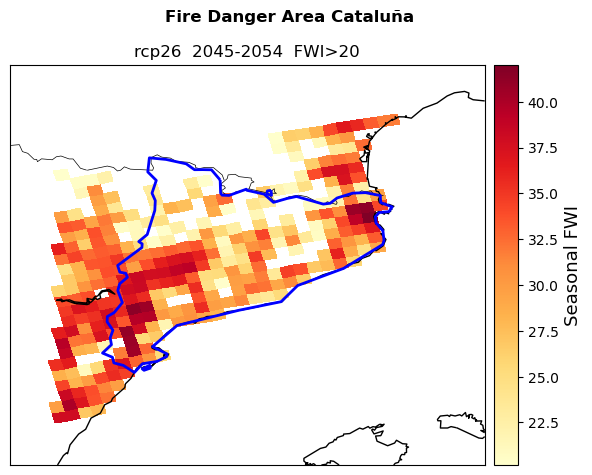

In [341]:
# Plot the seasonal FWI averaged over the selected period

ystart=ds_FWI['time.year'][0].to_numpy() #identify the projection start year
yend=ds_FWI['time.year'][-1].to_numpy() #identify the projection end year
#zoom parameter
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=danger['lon'].to_numpy()
lat_plot=danger['lat'][:].to_numpy()

#plot soil available water capacity
map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])

map_FWI.drawcoastlines()
map_FWI.drawcountries()
#map_FWI.contourf(lon_plot,lat_plot,danger_esa,cmap='Reds',zorder=1) 
map_FWI.pcolormesh(lon_plot,lat_plot,danger_esa,cmap='YlOrRd',zorder=1) 
map_FWI.colorbar().set_label('Seasonal FWI',fontsize=13)
map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
plt.suptitle('Fire Danger Area '+str(nuts.iloc[0,4]),fontweight='bold') #title
plt.title(rcp+' '+' '+str(ystart)+'-'+str(yend)+'  FWI>'+str(user_thresh))
plt.tight_layout()
plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_FireDanger.png') #save plots in results directory
plt.show()

## Add exposure elements to the danger dataset created above

### 1. Burnable area

In [13]:
#setting up the projection transformation tool
crs = ccrs.LambertAzimuthalEqualArea(central_longitude=10,central_latitude=52,
                                    false_easting=4321000,false_northing=3210000)
transformer = pyproj.Transformer.from_crs('epsg:4326',crs)

# New bbox coordinates matching EFFIS projection.
XLON_MIN, YLAT_MIN = transformer.transform(bbox[1], bbox[0])
XLON_MAX, YLAT_MAX = transformer.transform(bbox[3], bbox[2])

def cut_to_region_EFFIS(ds):
    ds = ds.sel(y = slice(YLAT_MAX, YLAT_MIN), x = slice(XLON_MIN, XLON_MAX))
    return ds

burn_area=xr.open_mfdataset(f'{data_dir}/var-PBAP_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)
burn_area

<xarray.Dataset> Size: 504kB
Dimensions:      (band: 1, x: 380, y: 328)
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 3kB 3.438e+06 3.44e+06 ... 3.816e+06 3.818e+06
  * y            (y) float64 3kB 2.268e+06 2.268e+06 ... 1.942e+06 1.942e+06
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float32 499kB dask.array<chunksize=(1, 1, 380), meta=np.ndarray>

#### Data processing
- Extract data from burnable area dataset
- Reproject to wgs84
- Interpolate to FWI resolution as done for ESA data

In [14]:
burn=burn_area['band_data'].mean(dim='band')
burn_wgs84=burn.rio.reproject("EPSG:4326",resampling=Resampling.average,nodata=np.nan)
coordinates_dict = {
    'x': danger['lon'],
    'y': danger['lat']}
burn_int=burn_wgs84.interp(coords=coordinates_dict)
mask=danger2>0
burn_final=burn_int*mask
burn_final=xr.where(burn_final>0,burn_final,np.nan)
burn_final=burn_final.mean(dim='time')

In [326]:
#assign the interpolated burnable area to the risk dataset
risk=risk.assign(burn_area=burn_final)

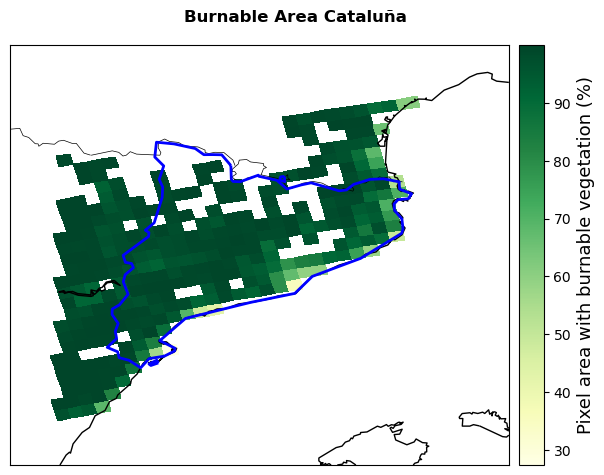

In [319]:
#Plot burnable area
#zoom parameter
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=danger['lon'].to_numpy()
lat_plot=danger['lat'][:].to_numpy()

#plot soil available water capacity
map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])

map_FWI.drawcoastlines()
map_FWI.drawcountries()
#map_FWI.contourf(lon_plot,lat_plot,burn_final*100,cmap='Reds',zorder=1) 
map_FWI.pcolormesh(lon_plot,lat_plot,burn_final*100,cmap='YlGn',zorder=1)
map_FWI.colorbar().set_label('Pixel area with burnable vegetation (%)',fontsize=13)
map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
plt.suptitle('Burnable Area '+str(nuts.iloc[0,4]),fontweight='bold') #title
plt.tight_layout()
plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_BurnArea.png') #save plots in results directory
plt.show()

### 2. Wildland Urban Interface

In [17]:
crs = ccrs.LambertAzimuthalEqualArea(central_longitude=10,central_latitude=52,
                                    false_easting=4321000,false_northing=3210000)
transformer = pyproj.Transformer.from_crs('epsg:4326',crs)

# New bbox coordinates matching EFFIS projection.
XLON_MIN, YLAT_MIN = transformer.transform(bbox[1], bbox[0])
XLON_MAX, YLAT_MAX = transformer.transform(bbox[3], bbox[2])

def cut_to_region_EFFIS(ds):
    ds = ds.sel(y = slice(YLAT_MAX, YLAT_MIN), x = slice(XLON_MIN, XLON_MAX))
    return ds

wui_ds=xr.open_mfdataset(f'{data_dir}/var-WUI-prop_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)

In [18]:
wui=wui_ds['band_data'].mean(dim='band')
wui_wgs84=wui.rio.reproject("EPSG:4326",resampling=Resampling.average,nodata=np.nan)
coordinates_dict = {
    'x': danger['lon'],
    'y': danger['lat']}
wui_int=wui_wgs84.interp(coords=coordinates_dict)
mask=danger2>0
wui_final=wui_int*mask
wui_final=xr.where(wui_final>0,wui_final,np.nan)
wui_final=wui_final.mean(dim='time')

In [327]:
risk=risk.assign(wu_interf=wui_final)

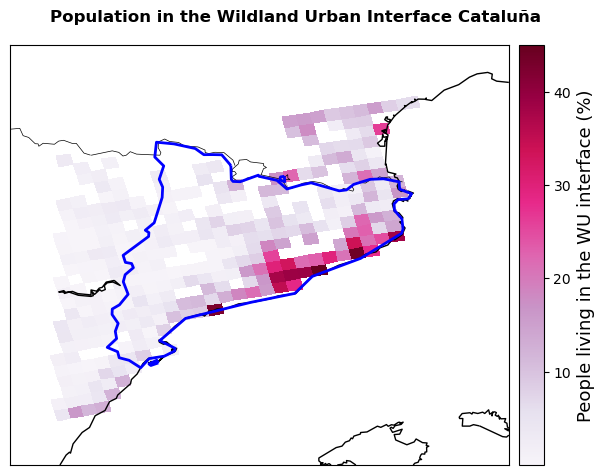

In [320]:
#Plot wildland urban interface 

#zoom parameter
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=danger['lon'].to_numpy()
lat_plot=danger['lat'][:].to_numpy()

#plot soil available water capacity
map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])

map_FWI.drawcoastlines()
map_FWI.drawcountries()
#map_FWI.contourf(lon_plot,lat_plot,wui_final*100,cmap='Reds',zorder=1)
map_FWI.pcolormesh(lon_plot,lat_plot,wui_final*100,cmap='PuRd',zorder=1)
map_FWI.colorbar().set_label('People living in the WU interface (%)',fontsize=13)
map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
plt.suptitle('Population in the Wildland Urban Interface '+str(nuts.iloc[0,4]),fontweight='bold') #title
plt.tight_layout()
plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_PopWUI.png') #save plots in results directory
plt.show()

### 3. Add protected areas fraction and irrepleceability

In [21]:
crs = ccrs.LambertAzimuthalEqualArea(central_longitude=10,central_latitude=52,
                                    false_easting=4321000,false_northing=3210000)
transformer = pyproj.Transformer.from_crs('epsg:4326',crs)

# New bbox coordinates matching EFFIS projection.
XLON_MIN, YLAT_MIN = transformer.transform(bbox[1], bbox[0])
XLON_MAX, YLAT_MAX = transformer.transform(bbox[3], bbox[2])

def cut_to_region_EFFIS(ds):
    ds = ds.sel(y = slice(YLAT_MAX, YLAT_MIN), x = slice(XLON_MIN, XLON_MAX))
    return ds

prot_area_ds=xr.open_mfdataset(f'{data_dir}/var-PAF_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)

In [22]:
prot_area=prot_area_ds['band_data'].mean(dim='band')
prot_area_wgs84=prot_area.rio.reproject("EPSG:4326",resampling=Resampling.average,nodata=np.nan)
coordinates_dict = {
    'x': danger['lon'],
    'y': danger['lat']}
prot_area_int=prot_area_wgs84.interp(coords=coordinates_dict)
mask=danger2>0
prot_area_final=prot_area_int*mask
prot_area_final=xr.where(prot_area_final>0,prot_area_final,np.nan)
prot_area_final=prot_area_final.mean(dim='time')

In [328]:
risk=risk.assign(prot_area=prot_area_final)

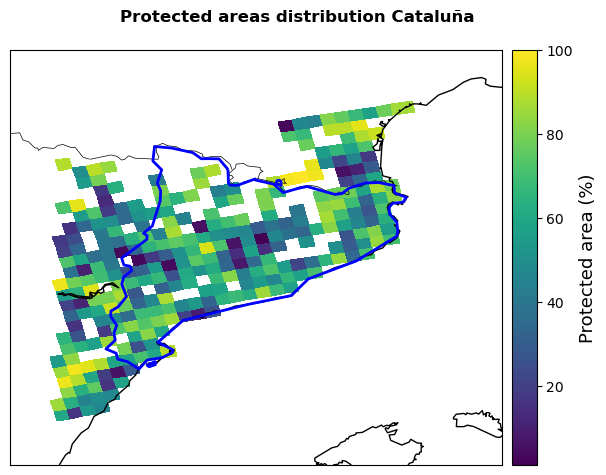

In [321]:
#zoom parameter
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=danger['lon'].to_numpy()
lat_plot=danger['lat'][:].to_numpy()

#plot soil available water capacity
map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])

map_FWI.drawcoastlines()
map_FWI.drawcountries()
#map_FWI.contourf(lon_plot,lat_plot,wui_final*100,cmap='Reds',zorder=1)
map_FWI.pcolormesh(lon_plot,lat_plot,prot_area_final*100,cmap='viridis',zorder=1)
map_FWI.colorbar().set_label('Protected area (%)',fontsize=13)
map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
plt.suptitle('Protected areas distribution '+str(nuts.iloc[0,4]),fontweight='bold') #title
plt.tight_layout()
plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_ProtAreas.png') #save plots in results directory
plt.show()

#### Irreplaceability

In [24]:
crs = ccrs.LambertAzimuthalEqualArea(central_longitude=10,central_latitude=52,
                                    false_easting=4321000,false_northing=3210000)
transformer = pyproj.Transformer.from_crs('epsg:4326',crs)

# New bbox coordinates matching EFFIS projection.
XLON_MIN, YLAT_MIN = transformer.transform(bbox[1], bbox[0])
XLON_MAX, YLAT_MAX = transformer.transform(bbox[3], bbox[2])

def cut_to_region_EFFIS(ds):
    ds = ds.sel(y = slice(YLAT_MAX, YLAT_MIN), x = slice(XLON_MIN, XLON_MAX))
    return ds

irrep_ds=xr.open_mfdataset(f'{data_dir}/var-Irr_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)

In [25]:
irrep=irrep_ds['band_data'].mean(dim='band')
irrep_wgs84=irrep.rio.reproject("EPSG:4326",resampling=Resampling.average,nodata=np.nan)
coordinates_dict = {
    'x': danger['lon'],
    'y': danger['lat']}
irrep_int=irrep_wgs84.interp(coords=coordinates_dict)
mask=danger2>0
irrep_final=irrep_int*mask
irrep_final=xr.where(irrep_final>0,irrep_final,np.nan)
irrep_final=irrep_final.mean(dim='time')

In [329]:
risk=risk.assign(ecol_irrep=irrep_final)

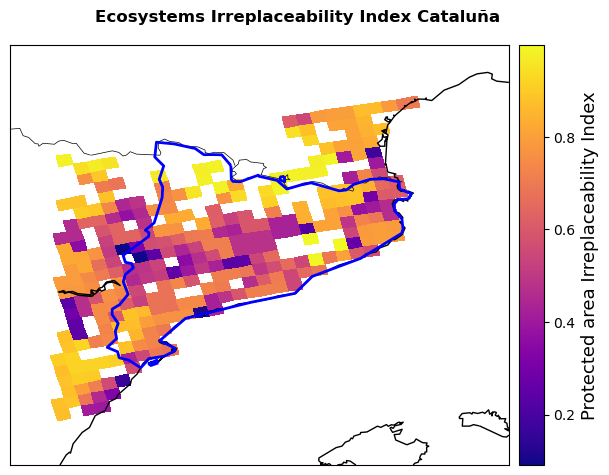

In [322]:
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=danger['lon'].to_numpy()
lat_plot=danger['lat'][:].to_numpy()

#plot soil available water capacity
map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])

map_FWI.drawcoastlines()
map_FWI.drawcountries()
#map_FWI.contourf(lon_plot,lat_plot,wui_final*100,cmap='Reds',zorder=1)
map_FWI.pcolormesh(lon_plot,lat_plot,irrep_final,cmap='plasma',zorder=1)
map_FWI.colorbar().set_label('Protected area Irreplaceability Index' ,fontsize=13)
map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
plt.suptitle('Ecosystems Irreplaceability Index '+str(nuts.iloc[0,4]),fontweight='bold') #title
plt.tight_layout()
plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_Irreplac.png') #save plots in results directory
plt.show()

### 4. Population density

In [27]:
crs = ccrs.LambertAzimuthalEqualArea(central_longitude=10,central_latitude=52,
                                    false_easting=4321000,false_northing=3210000)
transformer = pyproj.Transformer.from_crs('epsg:4326',crs)

# New bbox coordinates matching EFFIS projection.
XLON_MIN, YLAT_MIN = transformer.transform(bbox[1], bbox[0])
XLON_MAX, YLAT_MAX = transformer.transform(bbox[3], bbox[2])

def cut_to_region_EFFIS(ds):
    ds = ds.sel(y = slice(YLAT_MAX, YLAT_MIN), x = slice(XLON_MIN, XLON_MAX))
    return ds

pop_ds=xr.open_mfdataset(f'{data_dir}/var-pop_unit-people-per-km2.tiff',
                           preprocess=cut_to_region_EFFIS)

In [28]:
pop=pop_ds['band_data'].mean(dim='band')
pop_wgs84=pop.rio.reproject("EPSG:4326",resampling=Resampling.average,nodata=np.nan)
coordinates_dict = {
    'x': danger['lon'],
    'y': danger['lat']}
pop_int=pop_wgs84.interp(coords=coordinates_dict)
mask=danger2>0
pop_final=pop_int*mask
pop_final=xr.where(pop_final>0,pop_final,np.nan)
pop_final=pop_final.mean(dim='time')

In [330]:
risk=risk.assign(pop_dens=pop_final)

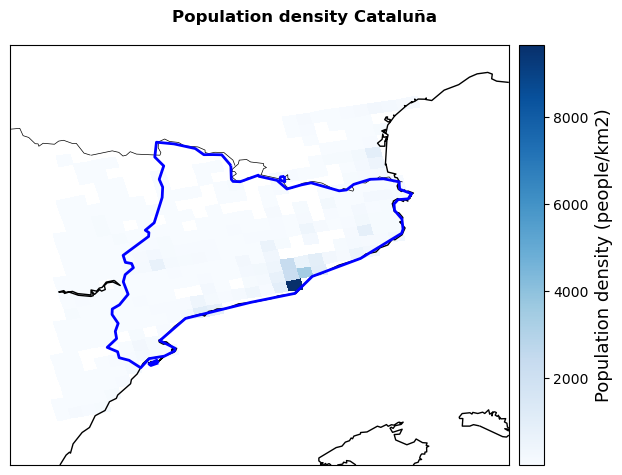

In [323]:
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=danger['lon'].to_numpy()
lat_plot=danger['lat'][:].to_numpy()

#plot soil available water capacity
map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])

map_FWI.drawcoastlines()
map_FWI.drawcountries()
#map_FWI.contourf(lon_plot,lat_plot,wui_final*100,cmap='Reds',zorder=1)
map_FWI.pcolormesh(lon_plot,lat_plot,pop_final,cmap='Blues',zorder=1)
map_FWI.colorbar().set_label('Population density (people/km2)' ,fontsize=13)
map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
plt.suptitle('Population density '+str(nuts.iloc[0,4]),fontweight='bold') #title
plt.tight_layout()
plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_PopDens.png') #save plots in results directory
plt.show()

### 5. Restoration cost

In [30]:
crs = ccrs.LambertAzimuthalEqualArea(central_longitude=10,central_latitude=52,
                                    false_easting=4321000,false_northing=3210000)
transformer = pyproj.Transformer.from_crs('epsg:4326',crs)

# New bbox coordinates matching EFFIS projection.
XLON_MIN, YLAT_MIN = transformer.transform(bbox[1], bbox[0])
XLON_MAX, YLAT_MAX = transformer.transform(bbox[3], bbox[2])

def cut_to_region_EFFIS(ds):
    ds = ds.sel(y = slice(YLAT_MAX, YLAT_MIN), x = slice(XLON_MIN, XLON_MAX))
    return ds

cost_ds=xr.open_mfdataset(f'{data_dir}/var-vuln-econ_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)

In [31]:
cost=cost_ds['band_data'].mean(dim='band')
cost_wgs84=cost.rio.reproject("EPSG:4326",resampling=Resampling.average,nodata=np.nan)
coordinates_dict = {
    'x': danger['lon'],
    'y': danger['lat']}
cost_int=cost_wgs84.interp(coords=coordinates_dict)
mask=danger2>0
cost_final=cost_int*mask
cost_final=xr.where(cost_final>0,cost_final,np.nan)
cost_final=cost_final.mean(dim='time')

In [331]:
risk=risk.assign(restor_cost=cost_final)

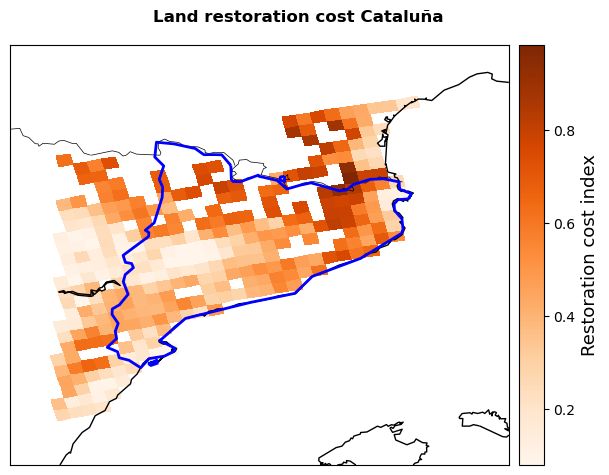

In [324]:
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=danger['lon'].to_numpy()
lat_plot=danger['lat'][:].to_numpy()

#plot soil available water capacity
map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])

map_FWI.drawcoastlines()
map_FWI.drawcountries()
#map_FWI.contourf(lon_plot,lat_plot,wui_final*100,cmap='Reds',zorder=1)
map_FWI.pcolormesh(lon_plot,lat_plot,cost_final,cmap='Oranges',zorder=1)
map_FWI.colorbar().set_label('Restoration cost index' ,fontsize=13)
map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
plt.suptitle('Land restoration cost '+str(nuts.iloc[0,4]),fontweight='bold') #title
plt.tight_layout()
plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_RestCost.png') #save plots in results directory
plt.show()

In [332]:
#Display the final risk Dataarray
risk

<xarray.Dataset> Size: 68kB
Dimensions:       (rlon: 32, rlat: 24)
Coordinates:
  * rlon          (rlon) float64 256B -14.07 -13.96 -13.86 ... -10.77 -10.55
  * rlat          (rlat) float64 192B -8.965 -8.855 -8.745 ... -6.545 -6.435
    rotated_pole  |S1 1B b''
    lon           (rlat, rlon) float64 6kB -0.2876 -0.15 -0.01225 ... 3.226 3.52
    lat           (rlat, rlon) float64 6kB 40.04 40.07 40.1 ... 43.24 43.28
    time          datetime64[ns] 8B 2022-01-01
    spatial_ref   int32 4B 0
    x             (rlat, rlon) float64 6kB -0.2876 -0.15 -0.01225 ... 3.226 3.52
    y             (rlat, rlon) float64 6kB 40.04 40.07 40.1 ... 43.24 43.28
Data variables:
    danger        (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>
    burn_area     (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>
    wu_interf     (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>
    prot_area     (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>
    ecol_irrep    (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>
    pop_dens      (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>
    restor_cost   (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>

### Pareto analysis of risk

In [333]:
risk_df=risk.to_dataframe()

In [371]:
paret_max=paretoset(risk_df[['burn_area','wu_interf','prot_area','ecol_irrep','restor_cost']],
                sense=[max,max,max,max,max])
paret_min=paretoset(risk_df[['burn_area','wu_interf','prot_area','ecol_irrep','restor_cost']],
                sense=[min,min,min,min,min])
max_pareto=risk_df[paret_max].to_xarray()
min_pareto=risk_df[paret_min].to_xarray()

In [372]:
max_pareto_sorted=max_pareto.sortby('rlon')
min_pareto_sorted=min_pareto.sortby('rlon')

In [373]:
rmax=max_pareto_sorted['danger']
rmin=min_pareto_sorted['danger']

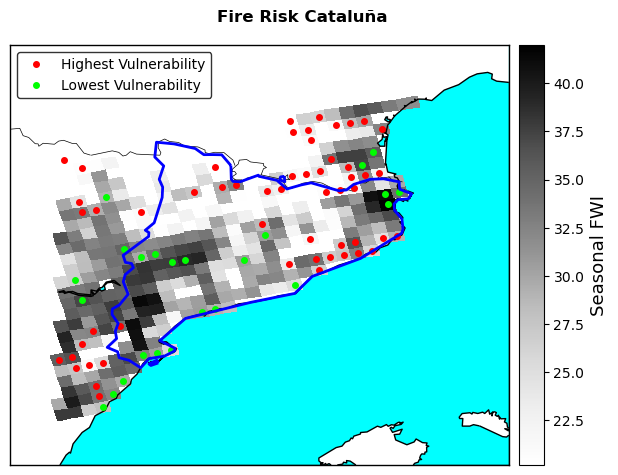

In [376]:
#zoom parameter
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=danger_esa['lon'].to_numpy()
lat_plot=danger_esa['lat'].to_numpy()

lon_max=max_pareto_sorted['lon'].squeeze()
lat_max=max_pareto_sorted['lat'].squeeze()

lon_min=min_pareto_sorted['lon'].squeeze()
lat_min=min_pareto_sorted['lat'].squeeze()


#plot soil available water capacity
map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])

map_FWI.drawcoastlines()
map_FWI.drawmapboundary(fill_color='aqua') 
map_FWI.fillcontinents(color='white',lake_color='aqua')
map_FWI.drawcountries()
#map_FWI.warpimage('https://basemaps.arcgis.com/v1/arcgis/rest/services/World_Basemap/VectorTileServer/tile/{z}/{y}/{x}.pbf')
map_FWI.pcolormesh(lon_plot,lat_plot,danger_esa,cmap='Greys') 
map_FWI.plot(lon_max,lat_max,rmax,marker='.',markersize=8,linestyle='None',color='r',label='Highest Vulnerability') 
map_FWI.plot(lon_min,lat_min,rmin,marker='.',markersize=8,linestyle='None',color='lime',label='Lowest Vulnerability') 

map_FWI.colorbar().set_label('Seasonal FWI',fontsize=13)
map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
plt.suptitle('Fire Risk '+str(nuts.iloc[0,4]),fontweight='bold') #title
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='best',edgecolor ='k')
plt.tight_layout()
plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_FireRisk.png') #save plots in results directory
plt.show()

In [379]:
#Plot results on geographical map
plt.plot(lon_max.fillna(np.nanmean(lon_max)),lat_max.fillna(np.nanmean(lat_max)),'.',color='r',markersize=11) 
plt.plot(lon_min.fillna(np.nanmean(lon_min)),lat_min.fillna(np.nanmean(lat_min)),'.',color='lime',markersize=11) 
mplleaflet.display()

### Contributors
Euro-Mediterranean Centre on Climate Change (CMCC), Italy

Author of the workflow: Andrea Rivosecchi

## OLDDDD

In [ ]:
###NEW

In [221]:
paret2=paret.reshape((len(risk['pop_dens'][:,0]),len(risk['pop_dens'][0,:])))
paret3=np.where(paret2==True)

In [222]:
rx=risk['pop_dens'][paret3].sortby('rlon')

In [231]:
rm

<xarray.DataArray 'danger' (rlon: 17, rlat: 16)> Size: 2kB
array([[20.17798519,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan, 25.69242411,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan, 29.51260166, 20.22862864,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan, 32.47717948,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,         nan,         nan,         nan, 23.42200102,
        32.27135444, 31.7091537 ,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
...
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan, 31.62267647,         nan,
                nan, 24.5477915 ,         nan,         nan,         nan,
                nan],
       [36.72051334,         nan,         nan,         nan,         nan,
                nan,         nan,         nan, 22.43878773,         nan,
                nan, 29.05444245,         nan,         nan,         nan,
                nan],
       [35.79166784,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
        32.4942071 ],
       [33.21205935,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan],
       [31.79684052,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan]])
Coordinates:
  * rlon     (rlon) float64 136B -13.41 -12.43 -12.32 ... -11.0 -10.89 -10.77
  * rlat     (rlat) float64 128B -6.435 -6.875 -6.985 ... -7.425 -7.205 -6.655

In [266]:
paret_max=paretoset(risk_df[['wu_interf','pop_dens','restor_cost']],
                sense=[max,max,max])
paret_min=paretoset(risk_df[['wu_interf','pop_dens','restor_cost']],
                sense=[min,min,min])
max_pareto=risk_df[paret_max].to_xarray()
min_pareto=risk_df[paret_min].to_xarray()

In [267]:
max_pareto_sorted=max_pareto.sortby('rlon')
min_pareto_sorted=min_pareto.sortby('rlon')

In [268]:
rmax=max_pareto_sorted['danger'].mean(dim='time')
rmin=min_pareto_sorted['danger'].mean(dim='time')

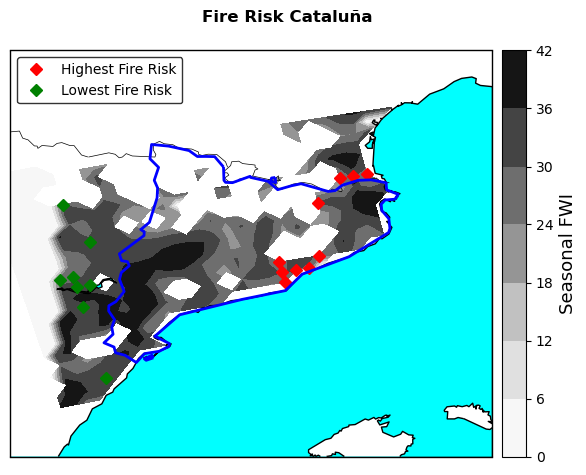

In [269]:
#Plot wildland urban interface 
import numpy.ma as ma
#zoom parameter
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=danger2['lon'].to_numpy()
lat_plot=danger2['lat'].to_numpy()

lon_max=max_pareto_sorted['lon'].squeeze()
lat_max=max_pareto_sorted['lat'].squeeze()

lon_min=min_pareto_sorted['lon'].squeeze()
lat_min=min_pareto_sorted['lat'].squeeze()


#plot soil available water capacity
map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])

map_FWI.drawcoastlines()
map_FWI.drawmapboundary(fill_color='aqua') 
map_FWI.fillcontinents(color='white',lake_color='aqua')
map_FWI.drawcountries()
#map_FWI.warpimage('https://basemaps.arcgis.com/v1/arcgis/rest/services/World_Basemap/VectorTileServer/tile/{z}/{y}/{x}.pbf')
map_FWI.contourf(lon_plot,lat_plot,danger2.squeeze(),cmap='Greys') 
map_FWI.plot(lon_max,lat_max,rmax,marker='D',linestyle='None',color='r',label='Highest Fire Risk') 
map_FWI.plot(lon_min,lat_min,rmin,marker='D',linestyle='None',color='g',label='Lowest Fire Risk') 
#map_FWI.contourf(lon_par,lat_par,rm) 
map_FWI.colorbar().set_label('Seasonal FWI',fontsize=13)
map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
plt.suptitle('Fire Risk '+str(nuts.iloc[0,4]),fontweight='bold') #title
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='best',edgecolor ='k')
plt.tight_layout()
#plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_SeasonalFWI.png') #save plots in results directory
plt.show()

In [271]:
#define the longitude and latitude coordinates
lon_plot=danger2['lon'].to_numpy()
lat_plot=danger2['lat'].to_numpy()

lon_par=risk_pareto_sorted['lon'].squeeze()
lat_par=risk_pareto_sorted['lat'].squeeze()

#plot soil available water capacity

#plt.hold(True)
plt.plot(lon_max.fillna(np.nanmean(lon_max)),lat_max.fillna(np.nanmean(lat_max)),'rs',markersize=11) 
plt.plot(lon_min.fillna(np.nanmean(lon_min)),lat_min.fillna(np.nanmean(lat_min)),'gs',markersize=11) 

#draw region boundaries from shapefile
#plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_SeasonalFWI.png') #save plots in results directory
mplleaflet.display()